# Reproducibility Project Group 21
**Semi-Supervised Medical Image Segmentation via Learning Consistency under Transformations**
by Gerda Bortsova, Florian Dubost, Laurens Hogeweg, Ioannis Katramados, Marleen de Bruijne

Reproduced by Jari Malfliet & Roemer Bakker

Supervised by Gerda Bortsova

TA: Olivia Huang

## CIFAR-10 Semi-supervised consistency classification

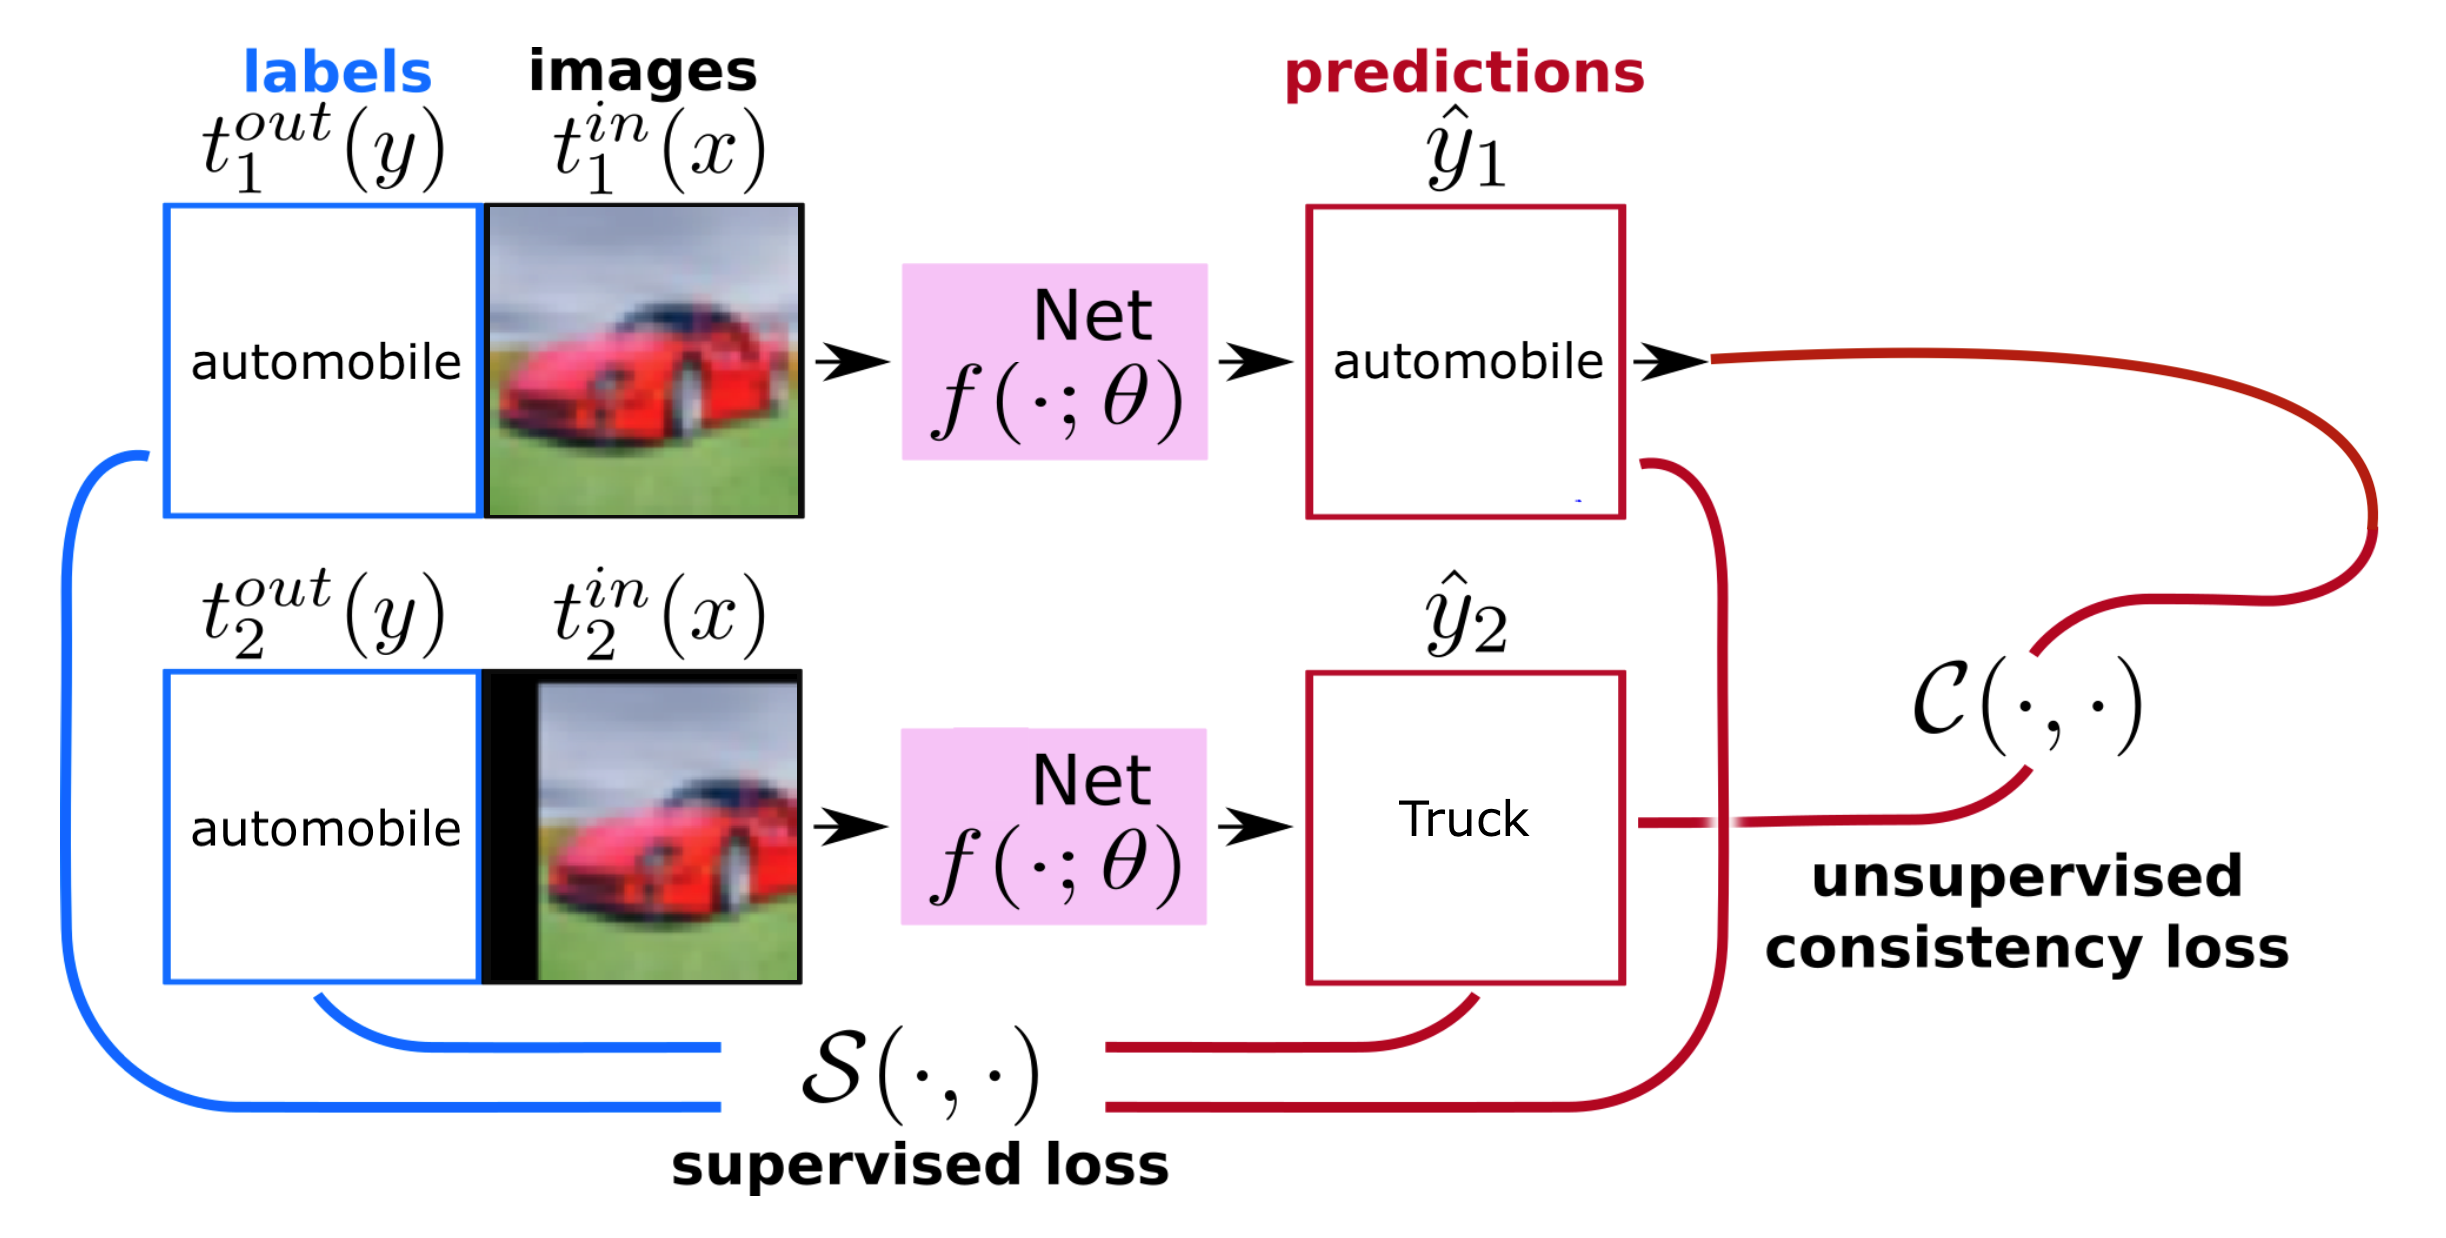

### Colab setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr  9 20:19:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install required packages:

In [ ]:
!pip install omegaconf==2.0.6

     |████████████████████████████████| 645kB 18.0MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install elasticdeform

     |████████████████████████████████| 102kB 8.5MB/s 


Run cell below to manually upload the .py and .yml files containing required functions and packages


*   models.py
*   func.py
*   datagen.py
*   improc.py


*   params_noise.yml
*   params_shift.yml
*   params_rotate.yml




In [ ]:
from google.colab import files
uploaded = files.upload()

Saving params_rotate_us.yml to params_rotate_us.yml
Saving improc.py to improc.py
Saving datagen.py to datagen.py
Saving func.py to func.py
Saving models.py to models.py


Import required packages and .py files:

In [ ]:
import os, time

import numpy as np
import pandas as pd
from omegaconf import OmegaConf

import tensorflow as tf

import func, models
from datagen import SimpleSequence

Create Colab directory and callback to save supervised training weights (training summary and evaluation also saved in this directory):

In [ ]:
!mkdir training_supervised

checkpoint_path = "/content/training_supervised/weights_sup.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


### Supervised training

Compile the supervised model with one of the params.yml files:

*   Noise transformation: params_noise.yml
*   Shift transformation: params_shift.yml
*   rotate transformation: params_rotate.yml






In [ ]:
# Model training and evaluation

# comment this line out to use gpu:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# sets the dimension order to 'channel_first', which the rest of the code assumes
tf.keras.backend.set_image_data_format("channels_first")

# %% Load and specify parameters

params_file = 'params_rotate.yml'

p = OmegaConf.load(params_file)

run_eagerly = False    # set to true to debug model training

# %% Data split parameters

# train-validation-test split

# semi-supervised learning:
if p.data_split == 'cifar10_ssl_default':
    data_split = {'trainIDs': range(49000), 'valIDs': range(49000, 50000),
                  'testIDs': range(50000, 60000)}
# supervised learning:
elif p.data_split == 'cifar10_default':
    data_split = {'trainIDs': range(4000), 'valIDs': range(49000, 50000),
                  'testIDs': range(50000, 60000)}
else:
    raise Exception('Data split not found: ', p.data_split)


# an indicator array indicatig whether a training example is labeled
labeled = np.ones((60000, ), dtype = bool)

if p.data_split == 'cifar10_ssl_default':
    labeled[4000:49000, ...] = False

# %% Data load and prep

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x = np.concatenate((x_train, x_test)).astype('float32')
y = np.concatenate((y_train, y_test))

# class numbers -> one-hot representation
y = tf.keras.utils.to_categorical(y)

data = {'x': x, 'y': y, 'labeled': labeled}


def get_data_subset(data, split, subset):
    """
    Select training, validation or testing portion of the data.
    """

    return {arr: data[arr][split[subset + 'IDs']] for arr in ['x', 'y', 'labeled']}

# %% Init generators


train_gen = SimpleSequence(p, data_split['trainIDs'],
                           data=get_data_subset(data, data_split, 'train'))

val_gen = SimpleSequence(p, data_split['valIDs'],
                         data=get_data_subset(data, data_split, 'val'))

test_gen = SimpleSequence(p, data_split['testIDs'],
                          data=get_data_subset(data, data_split, 'test'))


# %% Build the model architecture

model_arch = getattr(models, 'get_' + p.arch.name)(**p.arch.params)

model_arch.summary()

# %% Compile the model

# create an optimizer
opt = getattr(tf.keras.optimizers, p.optimizer.name)(**p.optimizer.params)

# create metrics
metrics = [getattr(tf.keras.metrics, metric_class)(name=('%s_%s' % (metric_type, metric_name)))
           for metric_type in ['sup', 'usup']
           for metric_class, metric_name in zip(['CategoricalAccuracy'], ['acc'])]


model = models.SemiSupervisedConsistencyModel(p, inputs = [model_arch.input],
                                              outputs = [model_arch.output])
model.compile(optimizer = opt, loss = getattr(func, p.loss),
              metrics = metrics, run_eagerly = run_eagerly)

# %% Train the model

start = time.time()

exp_folder = os.path.join(p.results_path, p.exp_name)
if not os.path.exists(exp_folder):
    os.makedirs(exp_folder)
if not os.path.exists(os.path.join(exp_folder, 'debug')):
    os.makedirs(os.path.join(exp_folder, 'debug'))

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('/content/training_supervised/training.csv'), separator = ",", append = False)

history = model.fit(x = train_gen,
                    epochs = p.epochs,
                    verbose = 1,
                    validation_data = val_gen,
                    callbacks = [csv_logger, cp_callback])

print('Training time: %.1f seconds.' % (time.time() - start))

# %% Evaluate the model on the test set

metric_values = model.evaluate(test_gen)

test_results = {'metric': model.metrics_names, 'value': metric_values}
pd.DataFrame(data = test_results).to_csv(os.path.join('/content/training_supervised/test.csv'), index = False)


print('\nTest results:')
for metric_name, metric_value in zip(model.metrics_names, metric_values):
    print('%s: %.3f' % (metric_name, metric_value))



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 32, 32)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 32, 32)        2688      
_________________________________________________________________
batch_normalization_9 (Batch (None, 96, 32, 32)        384       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 32, 32)        83040     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 32, 32)        384       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 32, 32)        83040     
_________________________________________________________________
batch_normalization_11 (Batc (None, 96, 32, 32)        384 

Create checkpoint that can be loaded in by the SSL model:

In [ ]:
os.listdir(checkpoint_dir)

['checkpoint',
 '.ipynb_checkpoints',
 'weights_sup.ckpt.index',
 'weights_sup.ckpt.data-00000-of-00001']

### Semi-supervised consistency training

Create Colab directory and callback to save SSL training (training summary also saved in this directory):

In [ ]:
!mkdir training_unsupervised

checkpoint_path_un = "/content/training_unsupervised/weights_unsup.ckpt"
checkpoint_dir_un = os.path.dirname(checkpoint_path_un)

# Create a callback that saves the model's weights
cp_callback_un = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_un,
                                                 save_weights_only=True,
                                                 verbose=1)

Upload .yml files required for ssl training:

*   params_noise_us.yml
*   params_shift_us.yml
*   params_rotate_us.yml



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving params_shift_us.yml to params_shift_us.yml


Compile the semi-supervised consistency model choosing one the same transformation as for the supervised training:

*   Noise transformation: params_noise_us.yml
*   Shift transformation: params_shift_us.yml
*   Rotate transformation: params_rotate_us.yml

In [ ]:
# Compile SSL model

import os, time

import numpy as np
import pandas as pd
from omegaconf import OmegaConf

import tensorflow as tf

import func, models
from datagen import SimpleSequence


# sets the dimension order to 'channel_first', which the rest of the code assumes
tf.keras.backend.set_image_data_format("channels_first")

# %% Load and specify parameters

params_file = 'params_noise_un.yml'

p = OmegaConf.load(params_file)

run_eagerly = False    # set to true to debug model training

# %% Data split parameters


# train-validation-test split

# semi-supervised learning:
if p.data_split == 'cifar10_ssl_default':
    data_split = {'trainIDs': range(49000), 'valIDs': range(49000, 50000),
                  'testIDs': range(50000, 60000)}
# supervised learning:
elif p.data_split == 'cifar10_default':
    data_split = {'trainIDs': range(4000), 'valIDs': range(49000, 50000),
                  'testIDs': range(50000, 60000)}
else:
    raise Exception('Data split not found: ', p.data_split)


# an indicator array indicatig whether a training example is labeled
labeled = np.ones((60000, ), dtype = bool)

if p.data_split == 'cifar10_ssl_default':
    labeled[4000:49000, ...] = False

# %% Data load and prep

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x = np.concatenate((x_train, x_test)).astype('float32')
y = np.concatenate((y_train, y_test))

# class numbers -> one-hot representation
y = tf.keras.utils.to_categorical(y)

data = {'x': x, 'y': y, 'labeled': labeled}


def get_data_subset(data, split, subset):
    """
    Select training, validation or testing portion of the data.
    """

    return {arr: data[arr][split[subset + 'IDs']] for arr in ['x', 'y', 'labeled']}

# %% Init generators


train_gen = SimpleSequence(p, data_split['trainIDs'],
                           data=get_data_subset(data, data_split, 'train'))

val_gen = SimpleSequence(p, data_split['valIDs'],
                         data=get_data_subset(data, data_split, 'val'))

test_gen = SimpleSequence(p, data_split['testIDs'],
                          data=get_data_subset(data, data_split, 'test'))


# %% Build the model architecture

model_arch = getattr(models, 'get_' + p.arch.name)(**p.arch.params)

model_arch.summary()

# %% Compile the model

# create an optimizer
opt = getattr(tf.keras.optimizers, p.optimizer.name)(**p.optimizer.params)

# create metrics
metrics = [getattr(tf.keras.metrics, metric_class)(name=('%s_%s' % (metric_type, metric_name)))
           for metric_type in ['sup', 'usup']
           for metric_class, metric_name in zip(['CategoricalAccuracy'], ['acc'])]


model = models.SemiSupervisedConsistencyModel(p, inputs = [model_arch.input],
                                              outputs = [model_arch.output])
model.compile(optimizer = opt, loss = getattr(func, p.loss),
              metrics = metrics, run_eagerly = run_eagerly)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3, 32, 32)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 96, 32, 32)        2688      
_________________________________________________________________
batch_normalization_36 (Batc (None, 96, 32, 32)        384       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 32, 32)        83040     
_________________________________________________________________
batch_normalization_37 (Batc (None, 96, 32, 32)        384       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 96, 32, 32)        83040     
_________________________________________________________________
batch_normalization_38 (Batc (None, 96, 32, 32)        384 

Test model without loading in weights:

In [ ]:
# %% Evaluate the model on the test set

metric_values = model.evaluate(test_gen)

test_results = {'metric': model.metrics_names, 'value': metric_values}
pd.DataFrame(data = test_results).to_csv(os.path.join('/content/training_unsupervised/load_test_nw.csv'), index = False)


print('\nTest results:')
for metric_name, metric_value in zip(model.metrics_names, metric_values):
    print('%s: %.3f' % (metric_name, metric_value))

79/79 [==============================] - 2s 26ms/step - loss: 2.9063 - loss_sup: 2.9017 - loss_usup: 0.0045 - sup_acc: 0.0999 - usup_acc: 1.0000

Test results:
loss: 2.906
loss_sup: 2.902
loss_usup: 0.005
sup_acc: 0.100
usup_acc: 1.000


Load in supervised weights:

In [ ]:
model.load_weights(checkpoint_path)



Test model with the supervised weights:

In [ ]:
# %% Evaluate the model on the test set

metric_values = model.evaluate(test_gen)

test_results = {'metric': model.metrics_names, 'value': metric_values}
pd.DataFrame(data = test_results).to_csv(os.path.join('/content/training_unsupervised/load_test.csv'), index = False)


print('\nTest results:')
for metric_name, metric_value in zip(model.metrics_names, metric_values):
    print('%s: %.3f' % (metric_name, metric_value))

79/79 [==============================] - 2s 27ms/step - loss: 2.4880 - loss_sup: 2.2755 - loss_usup: 0.2125 - sup_acc: 0.6382 - usup_acc: 0.8729

Test results:
loss: 2.488
loss_sup: 2.276
loss_usup: 0.213
sup_acc: 0.638
usup_acc: 0.873


Train the model with the semi-supervised consistency loss:

In [ ]:
# %% Train the model
model_arch.summary()

start = time.time()

exp_folder = os.path.join(p.results_path, p.exp_name)
if not os.path.exists(exp_folder):
    os.makedirs(exp_folder)
if not os.path.exists(os.path.join(exp_folder, 'debug')):
    os.makedirs(os.path.join(exp_folder, 'debug'))

csv_logger_un = tf.keras.callbacks.CSVLogger(os.path.join('/content/training_unsupervised/training_un.csv'), separator = ",", append = False)

history_un = model.fit(x = train_gen,
                    epochs = p.epochs,
                    verbose = 1,
                    validation_data = val_gen,
                    callbacks = [csv_logger_un, cp_callback_un])

print('Training time: %.1f seconds.' % (time.time() - start))

# %% Evaluate the model on the test set

metric_values = model.evaluate(test_gen)

test_results = {'metric': model.metrics_names, 'value': metric_values}
pd.DataFrame(data = test_results).to_csv(os.path.join('/content/training_unsupervised/test_un.csv'), index = False)


print('\nTest results:')
for metric_name, metric_value in zip(model.metrics_names, metric_values):
    print('%s: %.3f' % (metric_name, metric_value))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3, 32, 32)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 96, 32, 32)        2688      
_________________________________________________________________
batch_normalization_36 (Batc (None, 96, 32, 32)        384       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 32, 32)        83040     
_________________________________________________________________
batch_normalization_37 (Batc (None, 96, 32, 32)        384       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 96, 32, 32)        83040     
_________________________________________________________________
batch_normalization_38 (Batc (None, 96, 32, 32)        384 

KeyboardInterrupt: ignored